# PyGEM dhdt shop

Brandon Tober<br>

31OCT2025<br><br>

This notebook demonstrated PyGEM's 2d dhdt processing functionalityutulizing PyGEM's *sample_data* for Gulkana Glacier (RGI60-01.00570), which should have been downloaded during model installation and setup (see [here](https://pygem.readthedocs.io/en/latest/install_pygem.html)), but can also be downloaded directly [here](https://drive.google.com/drive/folders/1jbQvp0jKXkBZYi47EYhnPCPBcn3We068?usp=sharing).<br>

Tasks:
1. Load a glacier directory from PyGEM's sample dataset
2. Use PyGEM's shop.elevchange2d module to add any 2d dhdt data to our glacier directory
3. Compute the average glacierwide mass balance
4. Bin dhdt by glacier elevation

In [1]:
### imports ###
import os
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from IPython.display import display, JSON
from oggm import cfg, tasks, workflow
import pygem.pygem_modelsetup as modelsetup
from pygem.oggm_compat import update_cfg
from pygem.shop import elevchange2d, elevchange1d
from pygem.plot.graphics import plot_elev_change_1d
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.

# set some plotting defaults
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

cfg.initialize(logging_level='CRITICAL')
cfg.PATHS['working_dir'] = (
    f'{pygem_prms["root"]}/{pygem_prms["oggm"]["oggm_gdir_relpath"]}'
)

In [2]:
# initialize glacier directory
gdir = workflow.init_glacier_directories(['RGI60-01.00570'])[0];

### Process 2d dhdt data

Process 2d dhdt data to our glacier of interest. For a given single glacier directory we can run:
```{python}
elevchange2d.dhdt_to_gdir(gdir)
```

To run this function for many glaciers:
```{python}
workflow.execute_entity_task(elevchange2d.dhdt_to_gdir, gdirs)
```

In [3]:
elevchange2d.dhdt_to_gdir(gdir, verbose=True)

Found 1 files for RGI60-01.00570: ['N63W146_2000-01-01_2020-01-01_dhdt.tif']
Dataset time period:	2000-01-01 to 2020-01-01


Note, the example files in this sample dataset have the dtdt time period string embedded within the filenames, which `elevchange2d.dhdt_to_gdir()` tries to interpret - however, if such information is not stored within the file name, one can provide it, e.g.:

In [4]:
elevchange2d.dhdt_to_gdir(gdir, period='2000-01-01_2020-01-01', period_delimiter='_', date_format='YYYY-MM-DD', verbose=True)

Found 1 files for RGI60-01.00570: ['N63W146_2000-01-01_2020-01-01_dhdt.tif']
Dataset time period:	2000-01-01 to 2020-01-01


Alternatively, we could directly provide t1 and t2 strings:
```{python}
elevchange2d.dhdt_to_gdir(gdir, t1='2000-01-01', t2='2020-01-01',  date_format='YYYY-MM-DD', verbose=True)
```

In [5]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
ds

<xarray.Dataset> Size: 994kB
Dimensions:          (x: 272, y: 243)
Coordinates:
  * x                (x) float32 1kB -9.163e+03 -9.094e+03 ... 9.536e+03
  * y                (y) float32 972B 7.025e+06 7.025e+06 ... 7.008e+06
Data variables:
    topo             (y, x) float32 264kB 955.9 955.2 ... 1.351e+03 1.345e+03
    topo_smoothed    (y, x) float32 264kB 960.0 961.0 ... 1.344e+03 1.34e+03
    topo_valid_mask  (y, x) int8 66kB 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask     (y, x) int8 66kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext      (y, x) int8 66kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    dhdt             (y, x) float32 264kB -2.112 -2.233 ... 0.04523 0.04043
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=-145.427 +k=0.9996 +x_0=0 +y_...
    max_h_dem:      2693.9072
    min_h_dem:      931.6456
    max_h_glacier:  2402.1404
    min_h_glacier:  1162.817

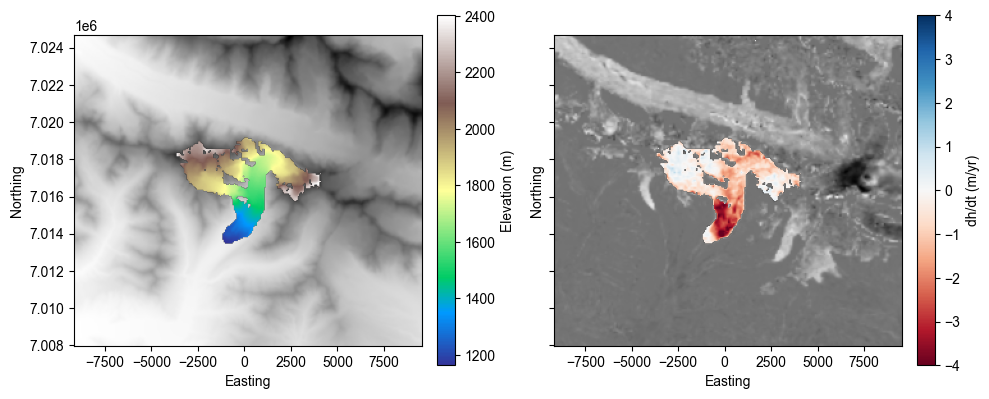

In [6]:
# plot
fig,ax  = plt.subplots(1,2,figsize=(10, 6), sharex=True, sharey=True)

# Extract coordinate names (adapt to your dataset)
x = ds.x.values 
y = ds.y.values

# Define extent = [xmin, xmax, ymin, ymax]
extent = [x.min(), x.max(), y.min(), y.max()]

ax[0].imshow(ds.topo.values, extent=extent, cmap='Greys')
im0 = ax[0].imshow(ds.topo.where(ds.glacier_mask), extent=extent, cmap='terrain')
ax[0].set_xlabel("Easting")
ax[0].set_ylabel("Northing")
# Add colorbar for topo
cbar0 = fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
cbar0.set_label("Elevation (m)")

ax[1].imshow(ds.dhdt.values, extent=extent, cmap='Greys')
vmax = np.round(np.nanmax(np.abs(ds.dhdt.where(ds.glacier_mask))))
im1 = ax[1].imshow(ds.dhdt.where(ds.glacier_mask), extent=extent, cmap='RdBu', vmin=-vmax, vmax=vmax)
ax[1].set_xlabel("Easting")
ax[1].set_ylabel("Northing")
# Add colorbar for dh/dt
cbar1 = fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
cbar1.set_label("dh/dt (m/yr)")

fig.tight_layout()

### Compute glacierwide avaerage elevation change and mass balance
We can compute some statistics on the 2d dhdt data using `elevchange2d.dhdt_statistics()`:

In [7]:
elevchange2d.dhdt_statistics(gdir)

{'rgi_id': 'RGI60-01.00570',
 'rgi_region': '01',
 'rgi_subregion': '01-02',
 'rgi_area_km2': 17.567,
 'area_km2': 17.577612,
 'perc_cov': 1.0,
 'avg_dhdt': -0.9216564,
 'dmdtda': -0.8294907867908478,
 'period': '2000-01-01_2020-01-01',
 't1': '2000-01-01',
 't2': '2020-01-01'}

Voilà, we have our average glacierwide mass balance from our dhdt data!

If we want to do this for a batch of glaciers:

```{python}
elevchange2d.compile_hugonnet_statistics(gdirs)
```

This function can also be passed a file path to store the statistics for all glaciers as a csv.

### Binning 
Now let's go through binning our 2d dhdt data. We can do this using OGGM's `elevation_band_flowline()` task, e.g.:

In [8]:
tasks.elevation_band_flowline(gdir,
                              bin_variables=['dhdt'],
                              )

Inspect binned dhdt data

In [9]:
import pandas as pd
df = pd.read_csv(gdir.get_filepath('elevation_band_flowline'), index_col=0)
df.head()

,area,mean_elevation,slope,dhdt,bin_elevation,dx,width
dis_along_flowline,,,,,,,
102.231389,33327.0,2345.320766,0.145686,-1.328452,2355.0,204.462778,162.997884
265.171789,114264.0,2322.244008,0.242229,-0.925008,2325.0,121.418023,941.079397
388.221778,119025.0,2290.567959,0.236124,-0.559489,2295.0,124.681955,954.628920
504.385780,295182.0,2264.390180,0.271795,-0.160982,2265.0,107.646049,2742.153583
599.405398,280899.0,2235.191386,0.349187,-0.315875,2235.0,82.393186,3409.250358


If we wish to calibrate against binned elevation change data, we need to convert from dhdt to dh and format in the structure PyGEM's `elevchange1d` module expects:

| bin_start | bin_stop | bin_area | date_start | date_end | dh | dh_sigma | ref_dem | ref_dem_year |
|------------|-----------|-----------|-------------|-----------|------|-----------|----------|---------------|
| edge0      | edge1     | area0     | date_start_1 | date_end_1 | dh_bin1_period1 | dh_sigma_bin1_period1 | ref_dem | ref_dem_year |
| edge1      | edge2     | area1     | date_start_1 | date_end_1 | dh_bin2_period1 | dh_sigma_bin2_period1 | ref_dem | ref_dem_year |
| ...        | ...       | ...       | ...         | ...       | ...  | ...       | ...      | ...           |
| edgeN-1    | edgeN     | areaN-1   | date_start_1 | date_end_1 | dh_binN-1_period1 | dh_sigma_binN-1_period1 | ref_dem | ref_dem_year |
| edge0      | edge1     | area0     | date_start_2 | date_end_2 | dh_bin1_period2 | dh_sigma_bin1_period2 | ref_dem | ref_dem_year |
| ...        | ...       | ...       | ...         | ...       | ...  | ...       | ...      | ...           |
| edgeN-1    | edgeN     | areaN-1   | date_start_M | date_end_M | dh_binN-1_periodM | dh_sigma_binN-1_periodM | ref_dem | ref_dem_year |

We can process to a format PyGEM accepts with a couple functions.

1.  `elevchange2d.dh_1d()` to bin the data as shown above and do some reformattiong (note we must provide a dhdt error).
2.  `elevchange1d.dh_1d_to_gdir()` to add the data to our glacier directory and validate the data formatting.

In [10]:
elevchange2d.dh_1d(gdir, dhdt_error=0.1)
elevchange1d.dh_1d_to_gdir(gdir)

Read the output

In [11]:
data = gdir.read_json('elev_change_1d')
display(JSON(data))

<IPython.core.display.JSON object>

Plot for a sanity check. We can use PyGEM's `graphics.plot_elev_change_1d()` function.

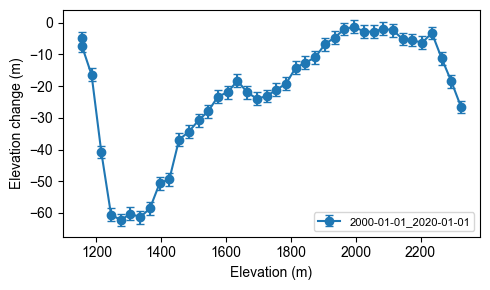

In [12]:
plot_elev_change_1d(gdir.read_json('elev_change_1d'))

Note, there's an inflection in the elevation change profile at the lowermost bins which are presumably deglaciated. In the profile above, we may also wish to remove some of the highest bins that show thinning, as these are data we may not wish to calibrate against. We can optionally remove bins by passing `bin_lowcut` and `bin_highcut` values to PyGEM's `elevchange1d.dh_1d_to_gdir()` function. These cutoff values can be in the form of an elevation percentile (default) or true elevation values (by specifying `bin_cutoff_percentile=False`). Only binned data above the specificed `bin_lowcut` and below the specified `bin_highcut` will remain after binning.

Let's test with `bin_lowcut=1250` m and `bin_highcut=2200` m:

In [13]:
elevchange1d.dh_1d_to_gdir(gdir, bin_lowcut=1250, bin_highcut=2200, bin_cut_percentile=False)

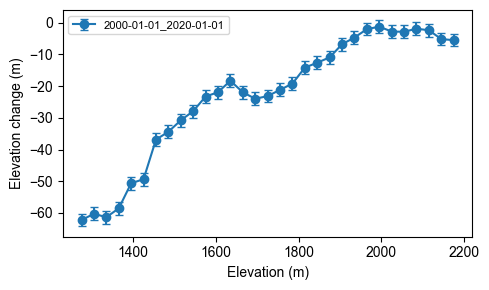

In [14]:
plot_elev_change_1d(gdir.read_json('elev_change_1d'))

### Multiple dhdt datasets?

We may potentially have multiple dhdt datasets we wish to process to a glacier directory and merge into multiple 1d elevation change records.

In [15]:
# process 2d dhdt data to gdir - specify gridded_data_suffix to keep track of different datasets
data_basedir = f'{pygem_prms["root"]}/{pygem_prms["calib"]["data"]["elev_change"]["dhdt_2d_relpath"]}/'
elevchange2d.dhdt_to_gdir(gdir, raster_path=os.path.join(data_basedir,'N63W146_2000-01-01_2020-01-01_dhdt.tif'), period_delimiter='_', gridded_data_suffix='_00-20', verbose=True)
elevchange2d.dhdt_to_gdir(gdir, raster_path=os.path.join(data_basedir,'2000-2005','N63W146_2000-01-01_2005-01-01_dhdt.tif'), period_delimiter='_', gridded_data_suffix='_00-05', verbose=True)
elevchange2d.dhdt_to_gdir(gdir, raster_path=os.path.join(data_basedir,'2015-2020','N63W146_2015-01-01_2020-01-01_dhdt.tif'), period_delimiter='_', gridded_data_suffix='_15-20', verbose=True)

Found 1 files for RGI60-01.00570: ['N63W146_2000-01-01_2020-01-01_dhdt.tif']
Dataset time period:	2000-01-01 to 2020-01-01
Found 1 files for RGI60-01.00570: ['N63W146_2000-01-01_2005-01-01_dhdt.tif']
Dataset time period:	2000-01-01 to 2005-01-01
Found 1 files for RGI60-01.00570: ['N63W146_2015-01-01_2020-01-01_dhdt.tif']
Dataset time period:	2015-01-01 to 2020-01-01


In [16]:
# optionally, compute statistics on each dataset - specify gridded_data_suffix to compute stats from each dataset
df1 = elevchange2d.dhdt_statistics(gdir, gridded_data_suffix='_00-20')
df2 = elevchange2d.dhdt_statistics(gdir, gridded_data_suffix='_00-05')
df3 = elevchange2d.dhdt_statistics(gdir, gridded_data_suffix='_15-20')
# merge the statistics dataframes
df_merged = pd.concat(map(pd.DataFrame, [[df1],[df2], [df3]]))
df_merged

,rgi_id,rgi_region,rgi_subregion,rgi_area_km2,area_km2,perc_cov,avg_dhdt,dmdtda,period,t1,t2
0,RGI60-01.00570,01,01-02,17.567,17.577612,1.0,-0.921656,-0.829491,2000-01-01_2020-01-01,2000-01-01,2020-01-01
0,RGI60-01.00570,01,01-02,17.567,17.577612,1.0,-0.686018,-0.617416,2000-01-01_2005-01-01,2000-01-01,2005-01-01
0,RGI60-01.00570,01,01-02,17.567,17.577612,1.0,-1.148302,-1.033472,2015-01-01_2020-01-01,2015-01-01,2020-01-01


In [17]:
# optionally save to csv
# df_merged.to_csv(f'{gdir.get_dir}/{'dhdt_statistics_merged.csv'})

In [18]:
# process to 1d elevation change
binneddf1 = elevchange2d.dh_1d(gdir, dhdt_error=0.1, gridded_data_suffix='_00-20', outfile_suffix='_00-20')
binneddf2 = elevchange2d.dh_1d(gdir, dhdt_error=0.1, gridded_data_suffix='_00-05', outfile_suffix='_00-05')
binneddf3 = elevchange2d.dh_1d(gdir, dhdt_error=0.1, gridded_data_suffix='_15-20', outfile_suffix='_15-20')
# concatenate arrays
merged_binneddf = pd.concat([binneddf1, binneddf2, binneddf3], axis=0)
merged_binneddf.to_csv(f'{pygem_prms["root"]}/{pygem_prms["calib"]["data"]["elev_change"]["dh_1d_relpath"]}/{(gdir.rgi_id).split('-')[1]}_elev_change_1d_merged.csv')
merged_binneddf

,bin_centers,bin_start,bin_stop,bin_area,date_start,date_end,dh,dh_sigma,ref_dem,ref_dem_year
dis_along_flowline,,,,,,,,,,
102.231389,2355.0,2370.0,2340.0,33327.0,2000-01-01,2020-01-01,-26.569044,2.000000,Copernicus DEM GLO-90,2012
265.171789,2325.0,2340.0,2310.0,114264.0,2000-01-01,2020-01-01,-18.500157,2.000000,Copernicus DEM GLO-90,2012
388.221778,2295.0,2310.0,2280.0,119025.0,2000-01-01,2020-01-01,-11.189790,2.000000,Copernicus DEM GLO-90,2012
504.385780,2265.0,2280.0,2250.0,295182.0,2000-01-01,2020-01-01,-3.219637,2.000000,Copernicus DEM GLO-90,2012
599.405398,2235.0,2250.0,2220.0,280899.0,2000-01-01,2020-01-01,-6.317510,2.000000,Copernicus DEM GLO-90,2012
...,...,...,...,...,...,...,...,...,...,...
6275.496056,1275.0,1290.0,1260.0,247572.0,2015-01-01,2020-01-01,-18.218946,0.499932,Copernicus DEM GLO-90,2012
6492.901958,1245.0,1260.0,1230.0,271377.0,2015-01-01,2020-01-01,-10.637622,0.499932,Copernicus DEM GLO-90,2012
6741.611142,1215.0,1230.0,1200.0,271377.0,2015-01-01,2020-01-01,-4.570810,0.499932,Copernicus DEM GLO-90,2012


In [19]:
# add to gdir as 1d elev change record - optionally rebin to a desired bin spacing, and apply lowcut/highcut filter if desired
elevchange1d.dh_1d_to_gdir(gdir, infile_suffix='_merged', bin_spacing=100, bin_lowcut=10, bin_highcut=90)

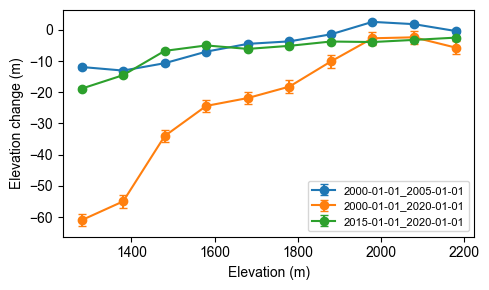

In [20]:
plot_elev_change_1d(gdir.read_json('elev_change_1d'))

Excellent, now we have a single 1d elevation change dataset added to our glacier directory. 

## Next: try a more advanced test
See, the [*advanced_test_spinup_elev_change_calib.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test_spinup_elev_change_calib.ipynb) Jupyter Notebook for information on calibrating against binned elevation change data.